<a href="https://colab.research.google.com/github/Masao-Taketani/FOTS_OCR/blob/master/Pix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
import os
import time
from matplotlib import pyplot as plt
from IPython import display

import tensorflow as tf
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, \
Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D

In [2]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'
path_to_zip = tf.keras.utils.get_file(fname="facades.tar.gz",
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), "facades/")
PATH

30171136/30168306 [==============================] - 1s 0us/step


'/root/.keras/datasets/facades/'

In [3]:
NUM_TRAIN = 400
BATCH_SIZE = 1
WIDTH = 256
HEIGHT = 256
OUTPUT_CHANNELS = 3
LAMBDA = 100

In [4]:
def load_img(img_file):
  img = tf.io.read_file(img_file)
  img = tf.image.decode_jpeg(img)

  w = tf.shape(img)[1]
  w = w // 2
  real_img = img[:, :w, :]
  input_img = img[:, w:, :]

  input_img = tf.cast(input_img, tf.float32)
  real_img = tf.cast(real_img, tf.float32)

  return input_img, real_img

def display_img(inp, real):
  plt.figure()
  plt.imshow(inp / 255.0)
  plt.figure()
  plt.imshow(real / 255.0)

def resize(input_img, real_img, height, width):
  input_img = tf.image.resize(input_img,
                              [height, width],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_img = tf.image.resize(real_img,
                             [height, width],
                             method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  return input_img, real_img

def random_crop(input_img, real_img):
  stacked_imgs = tf.stack([input_img, real_img], axis=0)
  cropped_img = tf.image.random_crop(stacked_imgs,
                                     size=[2, HEIGHT, WIDTH, 3])
  
  return cropped_img[0], cropped_img[1]

# normalize the image to [-1, 1]
def normalize(input_img, real_img):
  input_img = (input_img / 127.5) - 1
  real_img = (real_img / 127.5) - 1

  return input_img, real_img

@tf.function()
def random_jitter(input_img, real_img):
  # resize an image to (286 x 286 x 3)
  input_img, real_img = resize(input_img, real_img, 286, 286)
  # randomly crop an image to (256 x 256 x 3)
  input_img, real_img = random_crop(input_img, real_img)

  if tf.random.uniform(()) > 0.5:
    input_img = tf.image.flip_left_right(input_img)
    real_img = tf.image.flip_left_right(real_img)

  return input_img, real_img

def load_img_train(img_file):
  input_img, real_img = load_img(img_file)
  input_img, real_img = random_jitter(input_img, real_img)
  input_img, real_img = normalize(input_img, real_img)

  return input_img, real_img

def load_img_test(img_file):
  input_img, real_img = load_img(img_file)
  input_img, real_img = resize(input_img, real_img, HEIGHT, WIDTH)
  input_img, real_img = normalize(input_img, real_img)

  return input_img, real_img

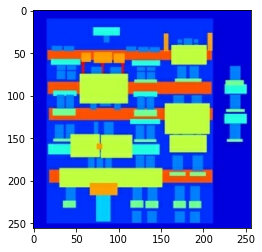

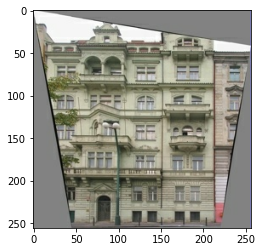

In [5]:
test_img = os.path.join(PATH, "train/100.jpg")
inp, real = load_img(test_img)
display_img(inp, real)

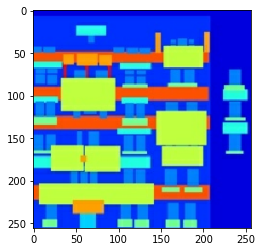

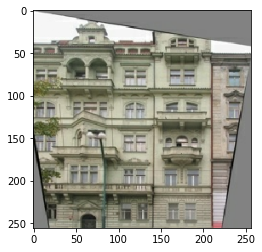

In [6]:
inp, real = load_img(os.path.join(PATH, "train/100.jpg"))
jittered_inp, jittered_real = random_jitter(inp, real)
display_img(jittered_inp, jittered_real)

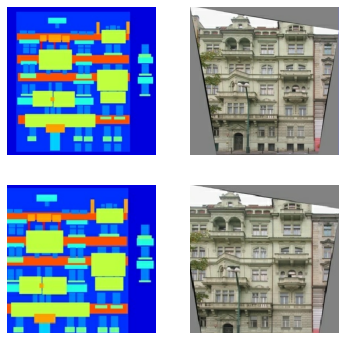

In [7]:
plt.figure(figsize=(6, 6))
for i, img in enumerate([inp, real, jittered_inp, jittered_real]):
  plt.subplot(2, 2, i+1)
  plt.imshow(img / 255.0)
  plt.axis("off")
plt.show()

In [8]:
# define input pipeline
train_dataset = tf.data.Dataset.list_files(os.path.join(PATH, "train/*.jpg"))
train_dataset = train_dataset.map(load_img_train,
                                  num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(NUM_TRAIN)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(os.path.join(PATH, "test/*.jpg"))
test_dataset = test_dataset.map(load_img_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [9]:
# build the generator
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(Conv2D(filters, 
                    size,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=False))
  if apply_batchnorm:
    result.add(BatchNormalization())
  result.add(LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(Conv2DTranspose(filters,
                             size,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
    result.add(Dropout(0.5))

  result.add(ReLU())

  return result

In [10]:
down_model = downsample(512, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print("shape of downsample:", down_result.shape)

up_model = upsample(3, 4)
up_result = up_model(down_result)
print("shape of upsample:", up_result.shape)

shape of downsample: (1, 128, 128, 512)
shape of upsample: (1, 256, 256, 3)


In [11]:
def Generator():
  inputs = Input(shape=[256, 256, 3])
  # () shows the shape after each downsample
  down_stack = [downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
                downsample(128, 4), # (bs, 64, 64, 128)
                downsample(256, 4), # (bs, 32, 32, 256)
                downsample(512, 4), # (bs, 16, 16, 512)
                downsample(512, 4), # (bs, 8, 8, 512)
                downsample(512, 4), # (bs, 4, 4, 512)
                downsample(512, 4), # (bs, 2, 2, 512)
                downsample(512, 4),] # (bs, 1, 1, 512)

  # () shows the shape after each upsample(* 2 shows concatinating with each skip connection)
  up_stack = [upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 512 * 2)
              upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 512 * 2)
              upsample(512, 4), # (bs, 8, 8, 512 * 2)
              upsample(512, 4), # (bs, 16, 16, 512 * 2)
              upsample(256, 4), # (bs, 32, 32, 256 * 2)
              upsample(128, 4), # (bs, 64, 64, 128 * 2)
              upsample(64, 4),] # (bs, 128, 128, 64 * 2)]

  initializer = tf.random_normal_initializer(0, 0.02)
  last = Conv2DTranspose(OUTPUT_CHANNELS,
                         4,
                         strides=2,
                         padding="same",
                         kernel_initializer=initializer,
                         activation="tanh") # (bs, 256, 256, 3)

  x = inputs
  # downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  # upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = Concatenate()([x, skip])
  x = last(x)

  return Model(inputs=inputs, outputs=x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


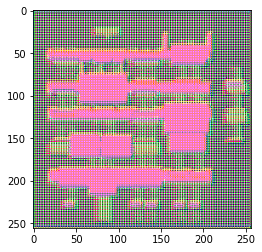

In [12]:
generator = Generator()
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [13]:
def generator_loss(disc_generated_output, gen_output, target):
  # As for the generator, it needs to try to decieve the discriminator as real outputs 
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  # MAE
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gan_loss, gan_loss, l1_loss

In [25]:
def Discriminator():
  initializer = tf.random_normal_initializer(0, 0.02)

  inp = Input(shape=[256, 256, 3], name="input_image")
  tar = Input(shape=[256, 256, 3], name="target_image")
  # tf.keras.layers.concatenate is used for Functional API
  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, 3 * 2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
  zero_pad1 = ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = Conv2D(512, 
                4, 
                strides=1,
                kernel_initializer=initializer,
                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
  batchnorm1 = BatchNormalization()(conv)
  leaky_relu = LeakyReLU()(batchnorm1)
  zero_pad2 = ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
  outputs = Conv2D(1, 
                   4, 
                   strides=1,
                   kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
  
  return Model(inputs=[inp, tar], outputs=outputs)

shape of disc_out: (1, 30, 30, 1)


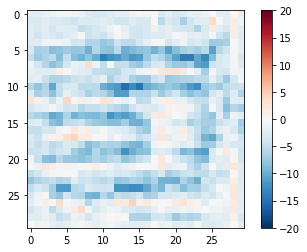

In [26]:
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
print("shape of disc_out:", disc_out.shape)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap="RdBu_r")
plt.colorbar()

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(disc_real_output, disc_generated_output):
  